In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import re
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

In [25]:
data = pd.read_excel('/content/drive/MyDrive/Maestria/Proyecto_fut/Data_Partidosxlsx.xlsx')
df = data.drop(columns=["|", "Video URL"])
df

,Subtitles,tar_ama_1,tar_ama_2,tar_roj_1,tar_roj_2,tiros_esquina_1,tiros_esquina_2,gol_1,gol_2,atajadas_1,...,posesion_1,posesion_2,faltas_1,faltas_2,tiros_1,tiros_2,penales_1,penales_2,penales_final_1,penales_final_2
0,WEBVTT Kind: captions Language: es entramos en...,3.0,4.0,0.0,1.0,5.0,3.0,4.0,1.0,3.0,...,0.547,0.453,14.0,18.0,19.0,14.0,0.0,0.0,0.0,0.0
1,WEBVTT Kind: captions Language: es rojas n√∫me...,0.0,2.0,0.0,0.0,NaN,NaN,3.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2,WEBVTT Kind: captions Language: es Bueno amigo...,1.0,1.0,0.0,0.0,13.0,3.0,0.0,2.0,4.0,...,0.570,0.430,21.0,19.0,11.0,9.0,0.0,0.0,0.0,0.0
3,WEBVTT Kind: captions Language: es [Aplausos] ...,1.0,1.0,0.0,0.0,NaN,NaN,2.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
4,WEBVTT Kind: captions Language: es I que va ae...,1.0,7.0,1.0,1.0,5.0,6.0,2.0,2.0,NaN,...,0.450,0.550,19.0,25.0,16.0,12.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,aquí estamos en el camp nou preparamos para v...,5.0,8.0,0.0,1.0,3.0,6.0,5.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
250,bajo la lluvia Real Sociedad Fútbol Club Barc...,2.0,2.0,0.0,0.0,7.0,3.0,2.0,4.0,1.0,...,0.490,0.510,14.0,13.0,15.0,11.0,0.0,0.0,0.0,0.0
251,[Música] señoras y señores muy buenas noches ...,4.0,3.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,...,NaN,NaN,23.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN
252,[Música] qué tal amigos saludos bienvenidos a...,1.0,2.0,0.0,0.0,9.0,4.0,8.0,2.0,1.0,...,0.680,0.320,6.0,12.0,30.0,7.0,1.0,0.0,0.0,0.0


In [26]:
for col in df:
    porcentaje = df[col].isnull().mean()
    if (porcentaje > 0):
        print(f'{col}: {porcentaje}')

tar_ama_1: 0.46062992125984253
tar_ama_2: 0.46062992125984253
tar_roj_1: 0.46062992125984253
tar_roj_2: 0.46062992125984253
tiros_esquina_1: 0.5078740157480315
tiros_esquina_2: 0.5078740157480315
gol_1: 0.46062992125984253
gol_2: 0.4566929133858268
atajadas_1: 0.5393700787401575
atajadas_2: 0.5433070866141733
posesion_1: 0.5
posesion_2: 0.5
faltas_1: 0.531496062992126
faltas_2: 0.531496062992126
tiros_1: 0.5354330708661418
tiros_2: 0.5354330708661418
penales_1: 0.47244094488188976
penales_2: 0.47244094488188976
penales_final_1: 0.47244094488188976
penales_final_2: 0.47244094488188976


In [27]:
df.dropna(inplace=True)

In [28]:
Y = df.drop(columns="Subtitles")
X = df["Subtitles"]
X.shape, Y.shape

((114,), (114, 20))

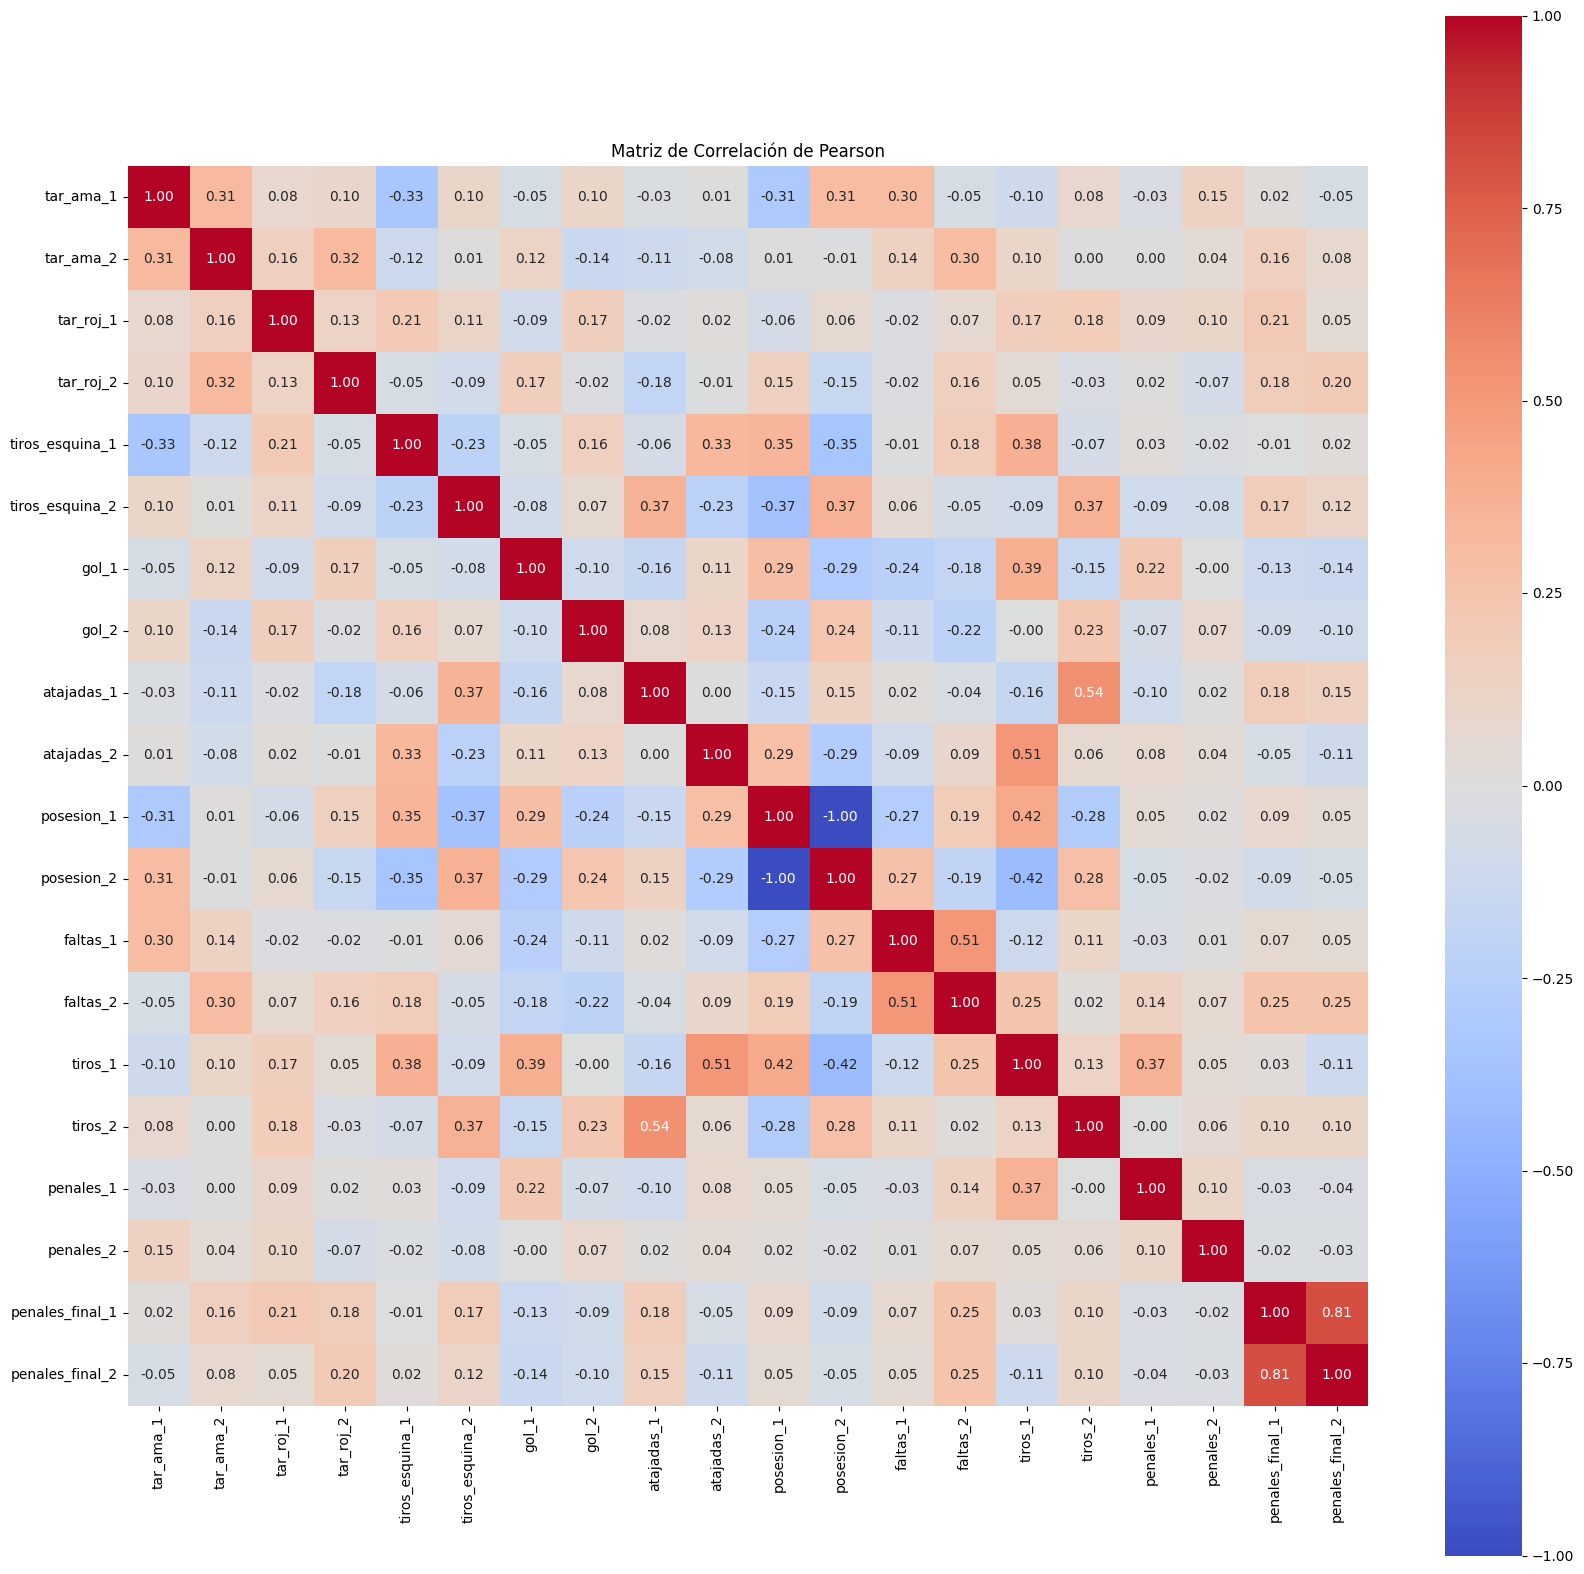

In [29]:
correlation_matrix = Y.corr(method='pearson')

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Matriz de Correlación de Pearson")
plt.show()


coolineales = np.where((abs(correlation_matrix) > 0.2) & (correlation_matrix != 1))

In [8]:
coolineales = np.array(coolineales).T
temp = []
j = 0
for i in coolineales:

    pasar = True
    for k in temp:
        if((i[0] == k[1]) & (i[1] == k[0])):
            pasar = False
    if(pasar):
        temp.insert(j, i)
        j = j + 1

coolineales = temp
coolineales = np.array(coolineales).transpose()
coolineales

array([[ 0,  0,  0,  0,  0,  1,  1,  2,  2,  4,  4,  4,  4,  4,  5,  5,
         5,  5,  5,  6,  6,  6,  6,  6,  7,  7,  7,  7,  8,  9,  9,  9,
        10, 10, 10, 10, 11, 11, 11, 12, 13, 13, 13, 14, 18],
       [ 1,  4, 10, 11, 12,  3, 13,  4, 18,  5,  9, 10, 11, 14,  8,  9,
        10, 11, 15, 10, 11, 12, 14, 16, 10, 11, 13, 15, 15, 10, 11, 14,
        11, 12, 14, 15, 12, 14, 15, 13, 14, 18, 19, 16, 19]])

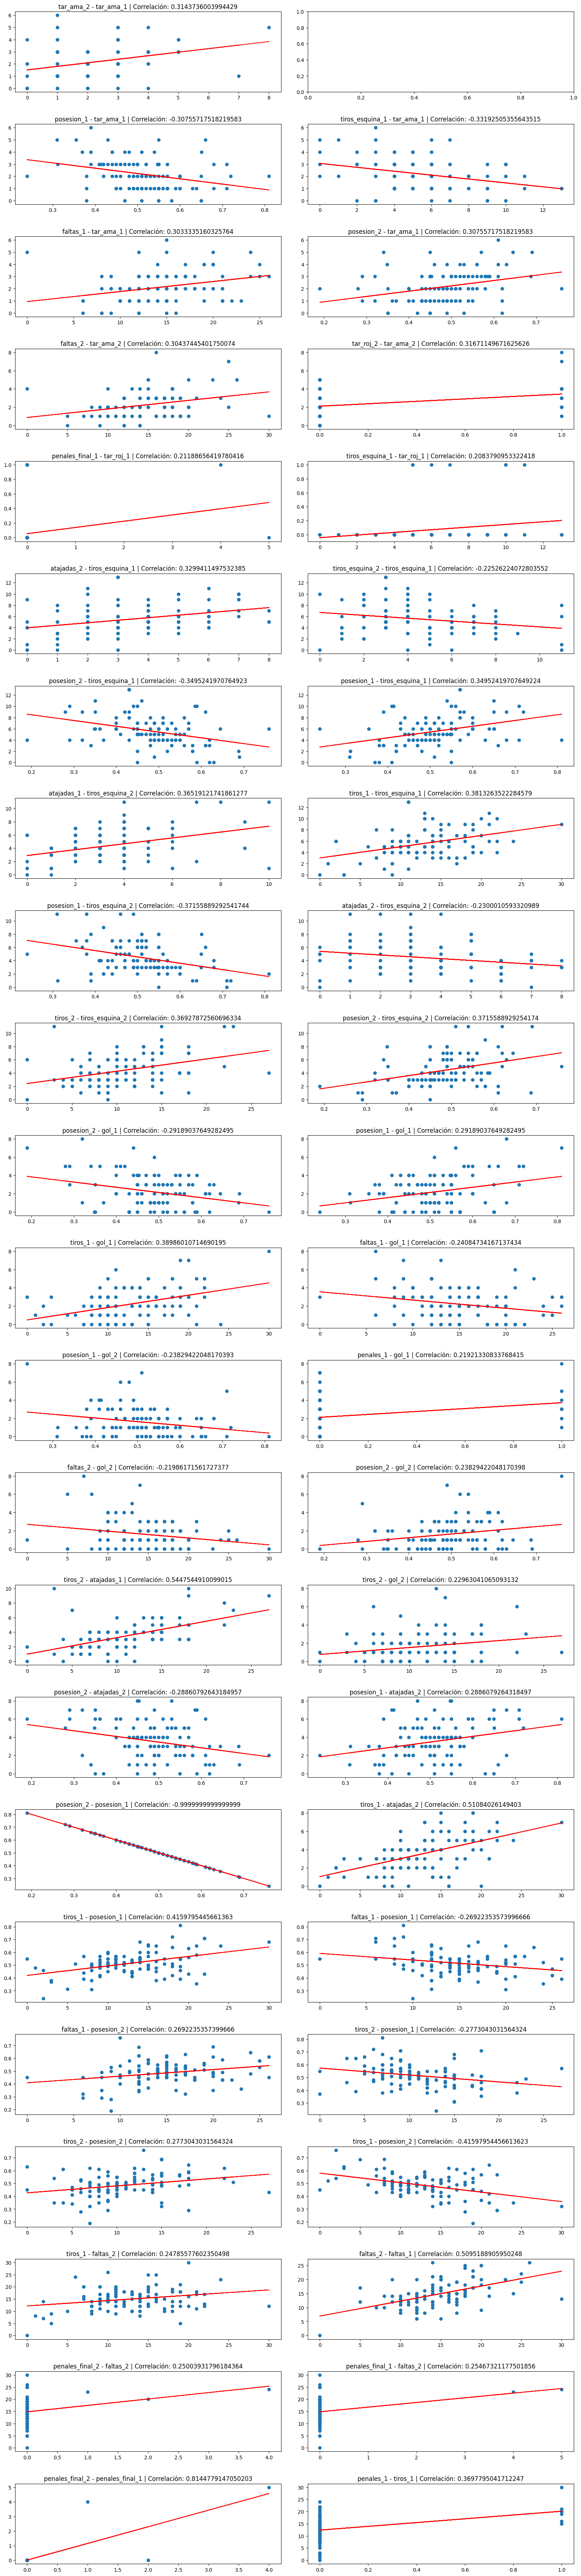

In [9]:
def corr_lineal(df):
  i = 0
  j = 0
  n = 2
  umbral = 0.50
  columnas = math.ceil(coolineales[0].size/n)
  #plt.figure(figsize=(12, 15))
  fig, axes = plt.subplots(columnas, n, figsize=(20, columnas*4))
  for k in range(coolineales[0].size):
      col = coolineales[0][k]
      ind = coolineales[1][k]

      x = df[correlation_matrix.index[ind]]
      y = df[correlation_matrix.columns[col]]

      # Filtrar nulos de ambas series (x, y)
      mask = x.notnull() & y.notnull()
      x_filtered = x[mask]
      y_filtered = y[mask]

      # Cálculos con los datos filtrados
      temp = np.corrcoef(x_filtered, y_filtered)[0][1]

      # Gráfica con los datos filtrados
      axes[i % columnas, j % n].scatter(x_filtered, y_filtered)

      # Ajuste de la línea con los datos filtrados
      coef = np.polyfit(x_filtered, y_filtered, 1)
      poly1d_fn = np.poly1d(coef)

      axes[i % columnas, j % n].plot(x, poly1d_fn(x), color="red")

      titulo = str(correlation_matrix.index[ind]) + " - " + str(correlation_matrix.columns[col]) + " | Correlación: " + str(temp)
      axes[i % columnas, j % n].set_title(titulo)

      j = j + 1
      if j % n == 1:
          i = i + 1

  plt.subplots_adjust(wspace=0.1, hspace=0.4)
  plt.show()
corr_lineal(Y)

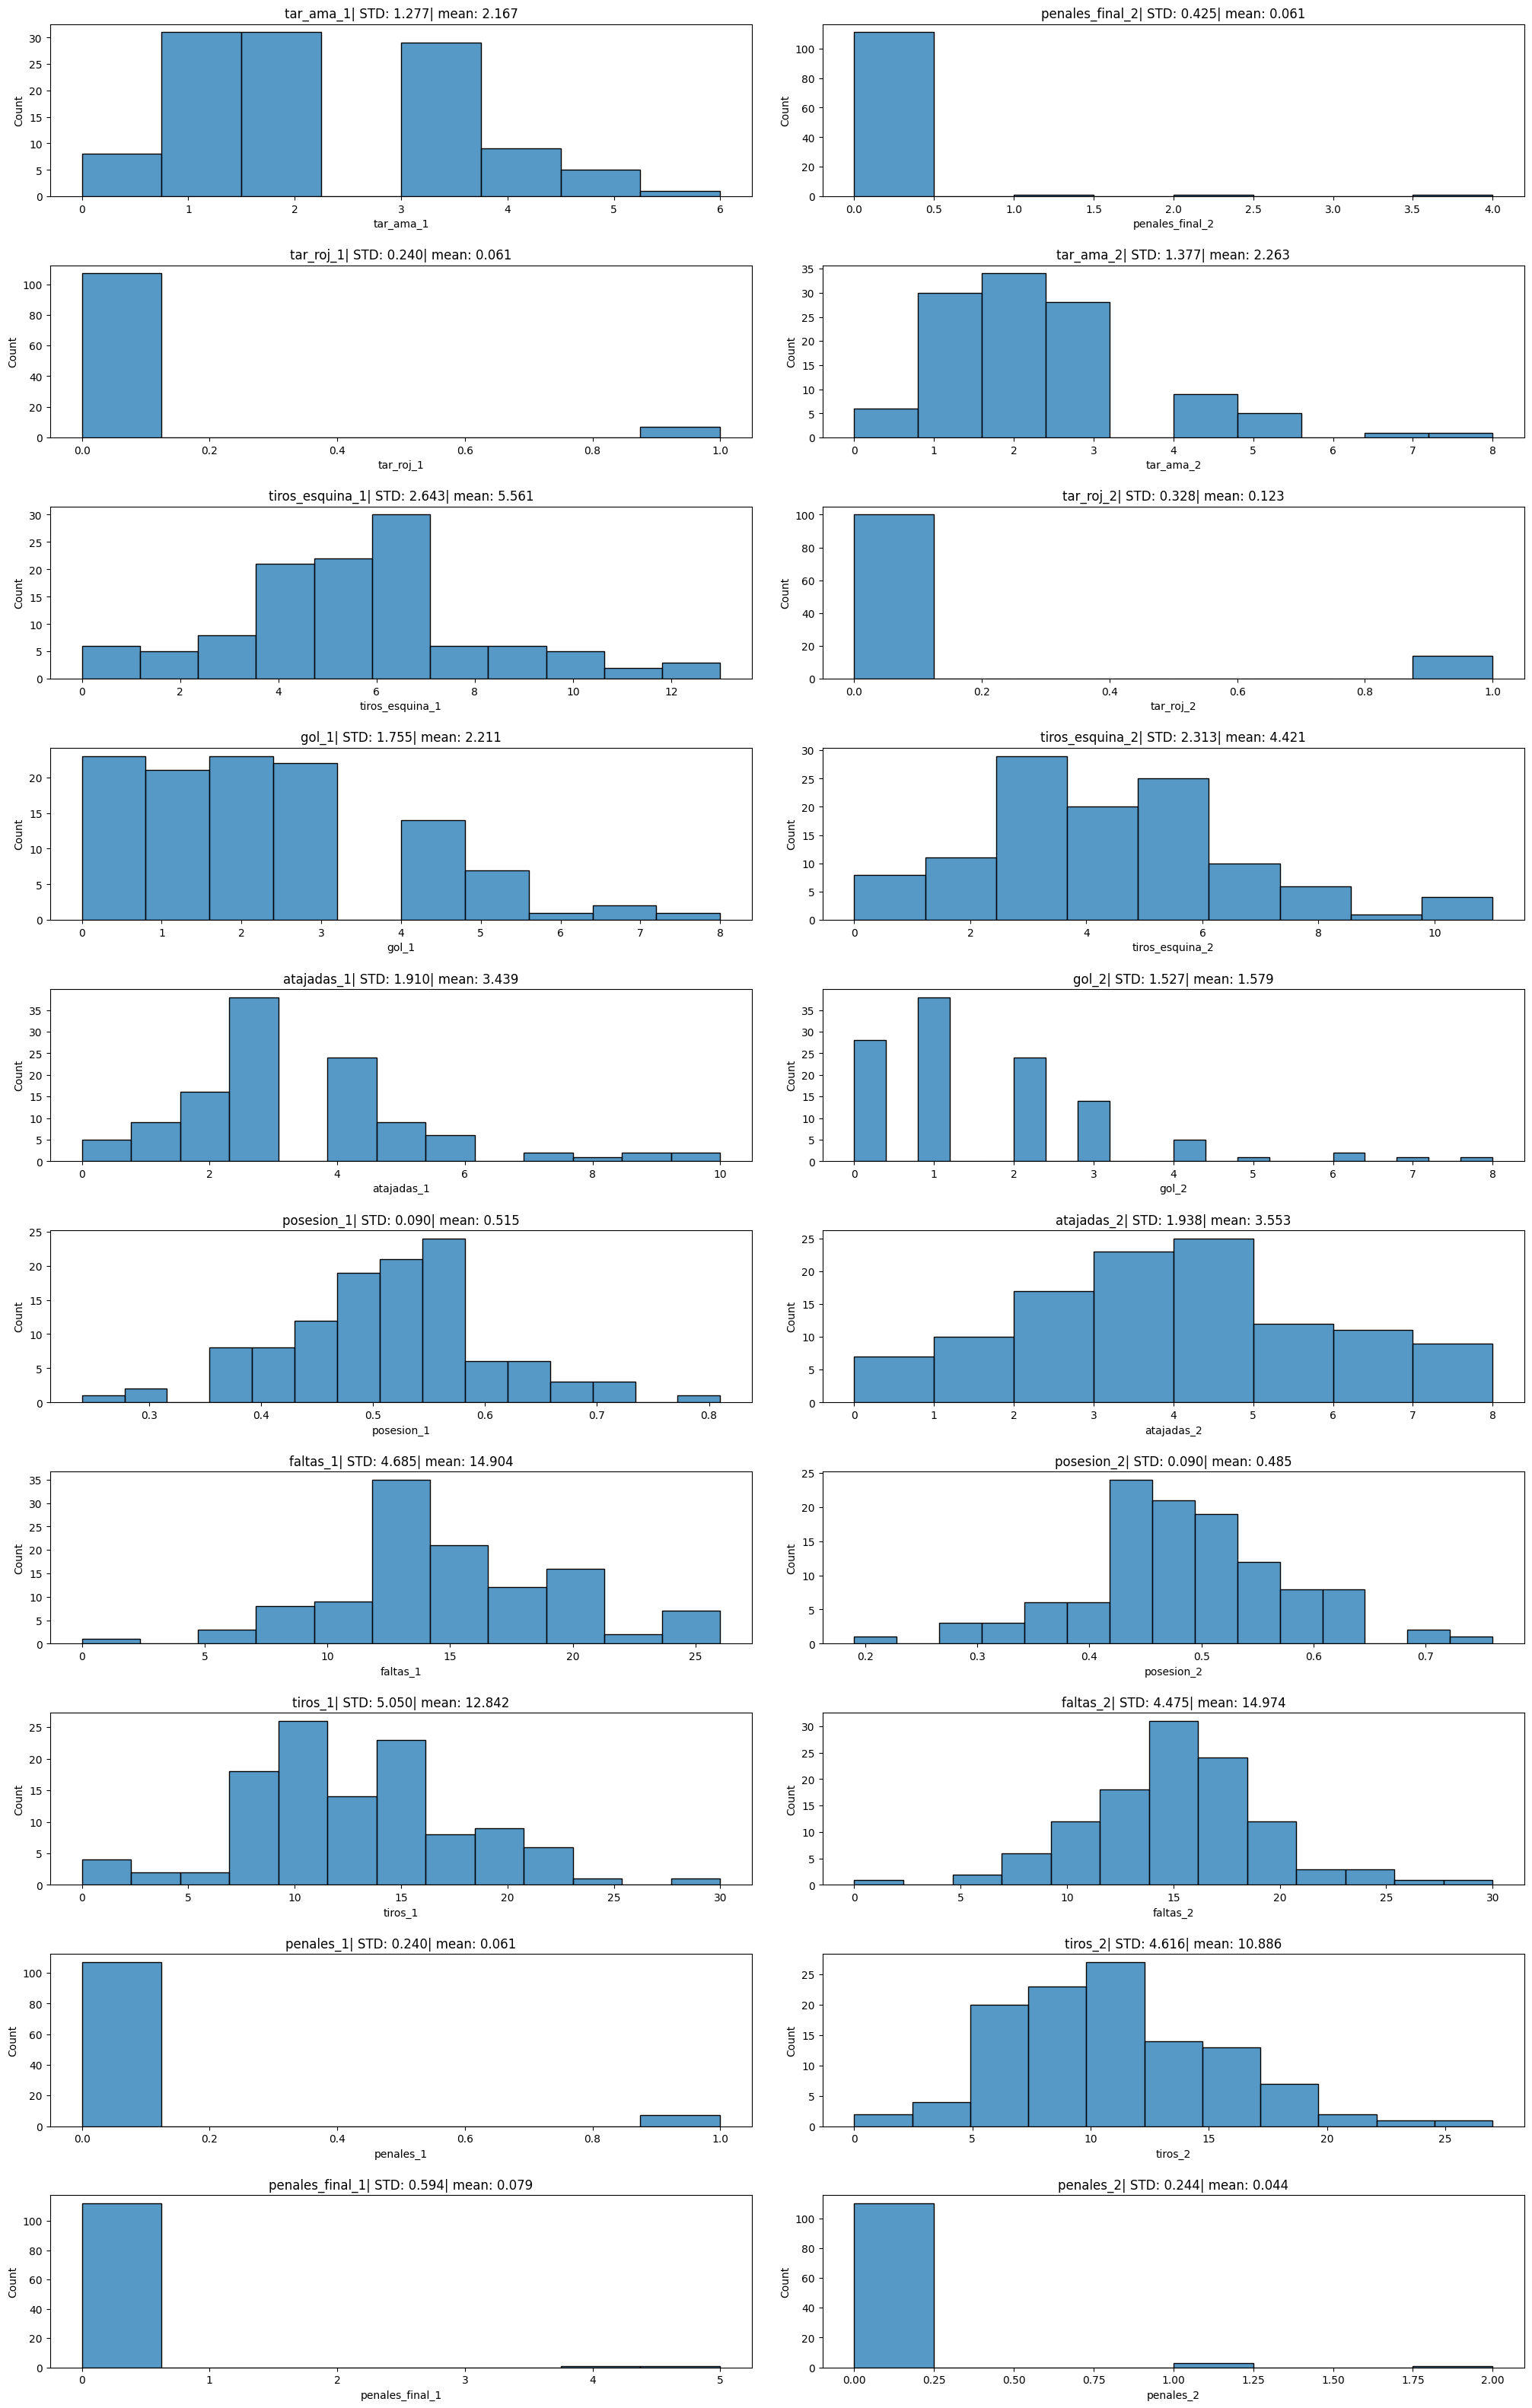

In [10]:
def distrubucion_var(df):
  i = 0
  j = 0
  n = 2
  umbral = 0.75
  columnas = math.ceil(df.columns.size/n)
  #plt.figure(figsize=(12, 15))
  fig, axes = plt.subplots(columnas, n, figsize=(25, 4*columnas))

  for col in df:
      sns.histplot(df[col], kde=False, ax=axes[i%columnas, j%n])
      titulo = f"{col}| STD: {np.std(df[col]):.3f}| mean: {np.mean(df[col]):.3f}"
      axes[i%columnas, j%n].set_title(titulo)

      j = j + 1
      if(j%n == 1) : i = i + 1

  plt.subplots_adjust(wspace=0.1, hspace=0.4)
  plt.show()
distrubucion_var(Y)

In [11]:
X = pd.DataFrame(X)
X

,Subtitles
0,WEBVTT Kind: captions Language: es entramos en...
2,WEBVTT Kind: captions Language: es Bueno amigo...
5,"WEBVTT Kind: captions Language: es de 2006, la..."
6,WEBVTT Kind: captions Language: es [Aplausos] ...
9,WEBVTT Kind: captions Language: es frente a la...
...,...
247,qué tal Cómo estáis Espero que bien Bienvenid...
248,[Aplausos] Saludos bienvenidos amigos del es...
250,bajo la lluvia Real Sociedad Fútbol Club Barc...
252,[Música] qué tal amigos saludos bienvenidos a...


# Steming Y Lematizacion

In [12]:
!pip install spacy

In [13]:
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 41.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [31]:
import nltk
import spacy
from nltk.stem import SnowballStemmer

In [51]:

# Función para limpiar los subtítulos eliminando metadatos y normalizando los caracteres
def clean_subtitles(text):
    text = re.sub(r'WEBVTT.*Language:', '', text)
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'\d{2}:\d{2}:\d{2}.\d{3} --> \d{2}:\d{2}:\d{2}.\d{3}', '', text)

    # Reemplazar tildes y mantener la ñ
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('ASCII')

    # Convertimos letras acentuadas a letras normales (a, e, i, o, u)
    text = re.sub(r'á', 'a', text)
    text = re.sub(r'é', 'e', text)
    text = re.sub(r'í', 'i', text)
    text = re.sub(r'ó', 'o', text)
    text = re.sub(r'ú', 'u', text)

    # Eliminar espacios adicionales
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Aplicar la limpieza al dataset
df['Cleaned_Subtitles'] = df['Subtitles'].apply(clean_subtitles)

In [89]:
df

,Subtitles,tar_ama_1,tar_ama_2,tar_roj_1,tar_roj_2,tiros_esquina_1,tiros_esquina_2,gol_1,gol_2,atajadas_1,...,faltas_2,tiros_1,tiros_2,penales_1,penales_2,penales_final_1,penales_final_2,Cleaned_Subtitles,stemmed_Subtitles,lemmatized_Subtitles
0,WEBVTT Kind: captions Language: es entramos en...,3.0,4.0,0.0,1.0,5.0,3.0,4.0,1.0,3.0,...,18.0,19.0,14.0,0.0,0.0,0.0,0.0,es entramos en el santeo bernabeu donde como v...,es entram en el sante bernabeu dond com ven se...,ser entrar en el santeo bernabeu donde como ve...
2,WEBVTT Kind: captions Language: es Bueno amigo...,1.0,1.0,0.0,0.0,13.0,3.0,0.0,2.0,4.0,...,19.0,11.0,9.0,0.0,0.0,0.0,0.0,"es Bueno amigos de la Rede Globo, hoy es para ...","es buen amig de la red glob , hoy es par val b...","ser bueno amigo de el Rede Globo , hoy ser par..."
5,"WEBVTT Kind: captions Language: es de 2006, la...",1.0,3.0,0.0,1.0,5.0,7.0,1.0,1.0,6.0,...,24.0,6.0,14.0,0.0,0.0,5.0,4.0,"es de 2006, la final nmero 18 desde la primera...","es de 2006 , la final nmer 18 desd la primer q...","ser de 2006 , el final nmero 18 desde el prime..."
6,WEBVTT Kind: captions Language: es [Aplausos] ...,4.0,3.0,0.0,0.0,5.0,7.0,0.0,1.0,5.0,...,17.0,13.0,15.0,0.0,0.0,0.0,0.0,es as= que dignidades de la realeza pol=ticos ...,es as= que dignidad de la realez pol=tic tod q...,ser as= que dignidad de el realeza pol = tico ...
9,WEBVTT Kind: captions Language: es frente a la...,4.0,3.0,0.0,0.0,5.0,3.0,1.0,3.0,3.0,...,15.0,9.0,11.0,0.0,0.0,0.0,0.0,es frente a la roma con la concepcin del gol q...,es frent a la rom con la concepcin del gol que...,ser frente a el roma con el concepcin del gol ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,qué tal Cómo estáis Espero que bien Bienvenid...,3.0,4.0,0.0,0.0,10.0,0.0,3.0,5.0,1.0,...,13.0,22.0,9.0,0.0,0.0,0.0,0.0,que tal Como estais Espero que bien Bienvenido...,que tal com estais esper que bien bienven a la...,que tal Como estai esperar que bien bienvenido...
248,[Aplausos] Saludos bienvenidos amigos del es...,3.0,2.0,0.0,0.0,6.0,3.0,4.0,3.0,3.0,...,17.0,22.0,14.0,0.0,0.0,0.0,0.0,Saludos bienvenidos amigos del espectadores bi...,salud bienven amig del espect bienven al vicen...,saludo bienvenido amigo del espectador bienven...
250,bajo la lluvia Real Sociedad Fútbol Club Barc...,2.0,2.0,0.0,0.0,7.0,3.0,2.0,4.0,1.0,...,13.0,15.0,11.0,0.0,0.0,0.0,0.0,bajo la lluvia Real Sociedad Futbol Club Barce...,baj la lluvi real socied futbol club barcelon ...,bajo el lluvia Real Sociedad Futbol Club Barce...
252,[Música] qué tal amigos saludos bienvenidos a...,1.0,2.0,0.0,0.0,9.0,4.0,8.0,2.0,1.0,...,12.0,30.0,7.0,1.0,0.0,0.0,0.0,que tal amigos saludos bienvenidos al candado ...,que tal amig salud bienven al cand bienven a b...,que tal amigo saludo bienvenido al candado bie...


In [90]:
df.to_csv("/content/drive/MyDrive/Maestria/Proyecto_fut/df_clean.csv", index=False)

In [159]:

# Descargar recursos de NLTK
nltk.download('punkt')

# Cargar el modelo de spaCy para lematización en español
nlp = spacy.load('es_core_news_sm')

# Crear el stemmer para español
stemmer = SnowballStemmer('spanish')

# Función para aplicar stemming
def stemming(text):
    words = nltk.word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

# Función para aplicar lematización
def lemmatization(text):
    doc = nlp(text)
    lemmatized_words = [token.lemma_ for token in doc]
    return ' '.join(lemmatized_words)

# Aplicar stemming
df['stemmed_Subtitles'] = df['Cleaned_Subtitles'].apply(stemming)

# Aplicar lematización después del stemming
df['lemmatized_Subtitles'] = df['stemmed_Subtitles'].apply(lemmatization)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [160]:
df

,Subtitles,tar_ama_1,tar_ama_2,tar_roj_1,tar_roj_2,tiros_esquina_1,tiros_esquina_2,gol_1,gol_2,atajadas_1,...,faltas_2,tiros_1,tiros_2,penales_1,penales_2,penales_final_1,penales_final_2,Cleaned_Subtitles,stemmed_Subtitles,lemmatized_Subtitles
0,WEBVTT Kind: captions Language: es entramos en...,3.0,4.0,0.0,1.0,5.0,3.0,4.0,1.0,3.0,...,18.0,19.0,14.0,0.0,0.0,0.0,0.0,es entramos en el santeo bernabeu donde como v...,es entram en el sante bernabeu dond com ven se...,ser entram en el sante bernabeu dond com ver é...
2,WEBVTT Kind: captions Language: es Bueno amigo...,1.0,1.0,0.0,0.0,13.0,3.0,0.0,2.0,4.0,...,19.0,11.0,9.0,0.0,0.0,0.0,0.0,"es Bueno amigos de la Rede Globo, hoy es para ...","es buen amig de la red glob , hoy es par val b...","ser buen amig de el red glob , hoy ser par val..."
5,"WEBVTT Kind: captions Language: es de 2006, la...",1.0,3.0,0.0,1.0,5.0,7.0,1.0,1.0,6.0,...,24.0,6.0,14.0,0.0,0.0,5.0,4.0,"es de 2006, la final nmero 18 desde la primera...","es de 2006 , la final nmer 18 desd la primer q...","ser de 2006 , el final nmer 18 desd el primero..."
6,WEBVTT Kind: captions Language: es [Aplausos] ...,4.0,3.0,0.0,0.0,5.0,7.0,0.0,1.0,5.0,...,17.0,13.0,15.0,0.0,0.0,0.0,0.0,es as= que dignidades de la realeza pol=ticos ...,es as= que dignidad de la realez pol=tic tod q...,ser as= que dignidad de el realez pol = tic to...
9,WEBVTT Kind: captions Language: es frente a la...,4.0,3.0,0.0,0.0,5.0,3.0,1.0,3.0,3.0,...,15.0,9.0,11.0,0.0,0.0,0.0,0.0,es frente a la roma con la concepcin del gol q...,es frent a la rom con la concepcin del gol que...,ser frent a el rom con el concepcin del gol qu...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,qué tal Cómo estáis Espero que bien Bienvenid...,3.0,4.0,0.0,0.0,10.0,0.0,3.0,5.0,1.0,...,13.0,22.0,9.0,0.0,0.0,0.0,0.0,que tal Como estais Espero que bien Bienvenido...,que tal com estais esper que bien bienven a la...,que tal com estai esper que bien bienvir a el ...
248,[Aplausos] Saludos bienvenidos amigos del es...,3.0,2.0,0.0,0.0,6.0,3.0,4.0,3.0,3.0,...,17.0,22.0,14.0,0.0,0.0,0.0,0.0,Saludos bienvenidos amigos del espectadores bi...,salud bienven amig del espect bienven al vicen...,salud bienvir amig del espect bienven al vicen...
250,bajo la lluvia Real Sociedad Fútbol Club Barc...,2.0,2.0,0.0,0.0,7.0,3.0,2.0,4.0,1.0,...,13.0,15.0,11.0,0.0,0.0,0.0,0.0,bajo la lluvia Real Sociedad Futbol Club Barce...,baj la lluvi real socied futbol club barcelon ...,baj el lluvi real socied futbol club barcelon ...
252,[Música] qué tal amigos saludos bienvenidos a...,1.0,2.0,0.0,0.0,9.0,4.0,8.0,2.0,1.0,...,12.0,30.0,7.0,1.0,0.0,0.0,0.0,que tal amigos saludos bienvenidos al candado ...,que tal amig salud bienven al cand bienven a b...,que tal amig salud bienvir al cand bienvir a b...


In [55]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [161]:
# Definimos EarlyStopping para detener el entrenamiento cuando el modelo deja de mejorar
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [162]:
# Vectorización con TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=500)  # Limitar a las 500 características más relevantes
X_tfidf = tfidf_vectorizer.fit_transform(df['lemmatized_Subtitles']).toarray()

# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, Y, test_size=0.2, random_state=42)

# Redimensionar los datos para que sean compatibles con LSTM (agregando una dimensión)
X_train_lstm = np.expand_dims(X_train, axis=-1)
X_test_lstm = np.expand_dims(X_test, axis=-1)

In [163]:
X_tfidf

array([[0.00676563, 0.00204508, 0.00591192, ..., 0.05735177, 0.00932881,
        0.30060167],
       [0.01197834, 0.01034501, 0.00598107, ..., 0.00892655, 0.00566276,
        0.15498307],
       [0.00379912, 0.        , 0.01327894, ..., 0.024773  , 0.        ,
        0.26131177],
       ...,
       [0.00167813, 0.00811612, 0.00586551, ..., 0.02772129, 0.00555335,
        0.27673429],
       [0.00166675, 0.        , 0.00388381, ..., 0.01883852, 0.00551567,
        0.21219512],
       [0.00148833, 0.00359907, 0.        , ..., 0.        , 0.00656698,
        0.18948017]])

In [164]:
model = Sequential([
    LSTM(128, input_shape=(X_train_lstm.shape[1], 1), return_sequences=False),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.3),  # Añadimos dropout después de la LSTM
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),  # Añadimos dropout antes de la capa final
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),  # Añadimos dropout antes de la capa final
    Dense(Y.shape[1], activation='linear')
])


model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train_lstm,
          y_train,
          epochs=100,
          batch_size=32,
          validation_data=(X_test_lstm, y_test),
          callbacks=[early_stopping]
          )


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 48.5429 - val_loss: 42.9888
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 566ms/step - loss: 47.6237 - val_loss: 42.6832
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 568ms/step - loss: 47.4894 - val_loss: 41.2678
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 575ms/step - loss: 43.9470 - val_loss: 32.1252
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 577ms/step - loss: 35.7064 - val_loss: 24.9237
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 28.3844 - val_loss: 18.4688
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 578ms/step - loss: 26.5202 - val_loss: 13.0003
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 588ms/step - loss: 23.6905 - val_loss: 9.4816
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 588ms/step - loss: 21.4368 - val_loss: 7.9528
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 577ms/step - loss: 17.8017 - val_loss: 7.9619
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 17.8356 - val_loss: 8.1960
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 649ms/step - 

In [165]:
y_pred = model.predict(X_test_lstm)
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


array([[ 1.9253145 ,  1.9705931 ,  0.17066537,  0.07558981,  4.9741364 ,
         4.200759  ,  1.7439282 ,  1.5528789 ,  3.393198  ,  3.2630591 ,
         0.41810408,  0.3864219 , 13.683839  , 13.4785    , 11.336283  ,
         9.797807  ,  0.22517785, -0.04478762,  0.3375433 , -0.02797481],
       [ 1.9242245 ,  1.9696951 ,  0.17041002,  0.07582471,  4.9707127 ,
         4.19766   ,  1.7427269 ,  1.5517572 ,  3.3901014 ,  3.260181  ,
         0.41810766,  0.38612387, 13.673684  , 13.467881  , 11.327732  ,
         9.790278  ,  0.22513264, -0.04439244,  0.3374901 , -0.02802911],
       [ 1.9239924 ,  1.969517  ,  0.17035201,  0.07588206,  4.9699864 ,
         4.1970134 ,  1.7424729 ,  1.5515212 ,  3.3894362 ,  3.2595751 ,
         0.41810027,  0.3860656 , 13.6715355 , 13.46564   , 11.325931  ,
         9.788705  ,  0.22512597, -0.04430632,  0.33747628, -0.02803269],
       [ 1.9248431 ,  1.9701998 ,  0.17055368,  0.07568839,  4.972666  ,
         4.199419  ,  1.7434078 ,  1.552399  ,  

In [166]:
test =  y_test.reset_index(drop=True)

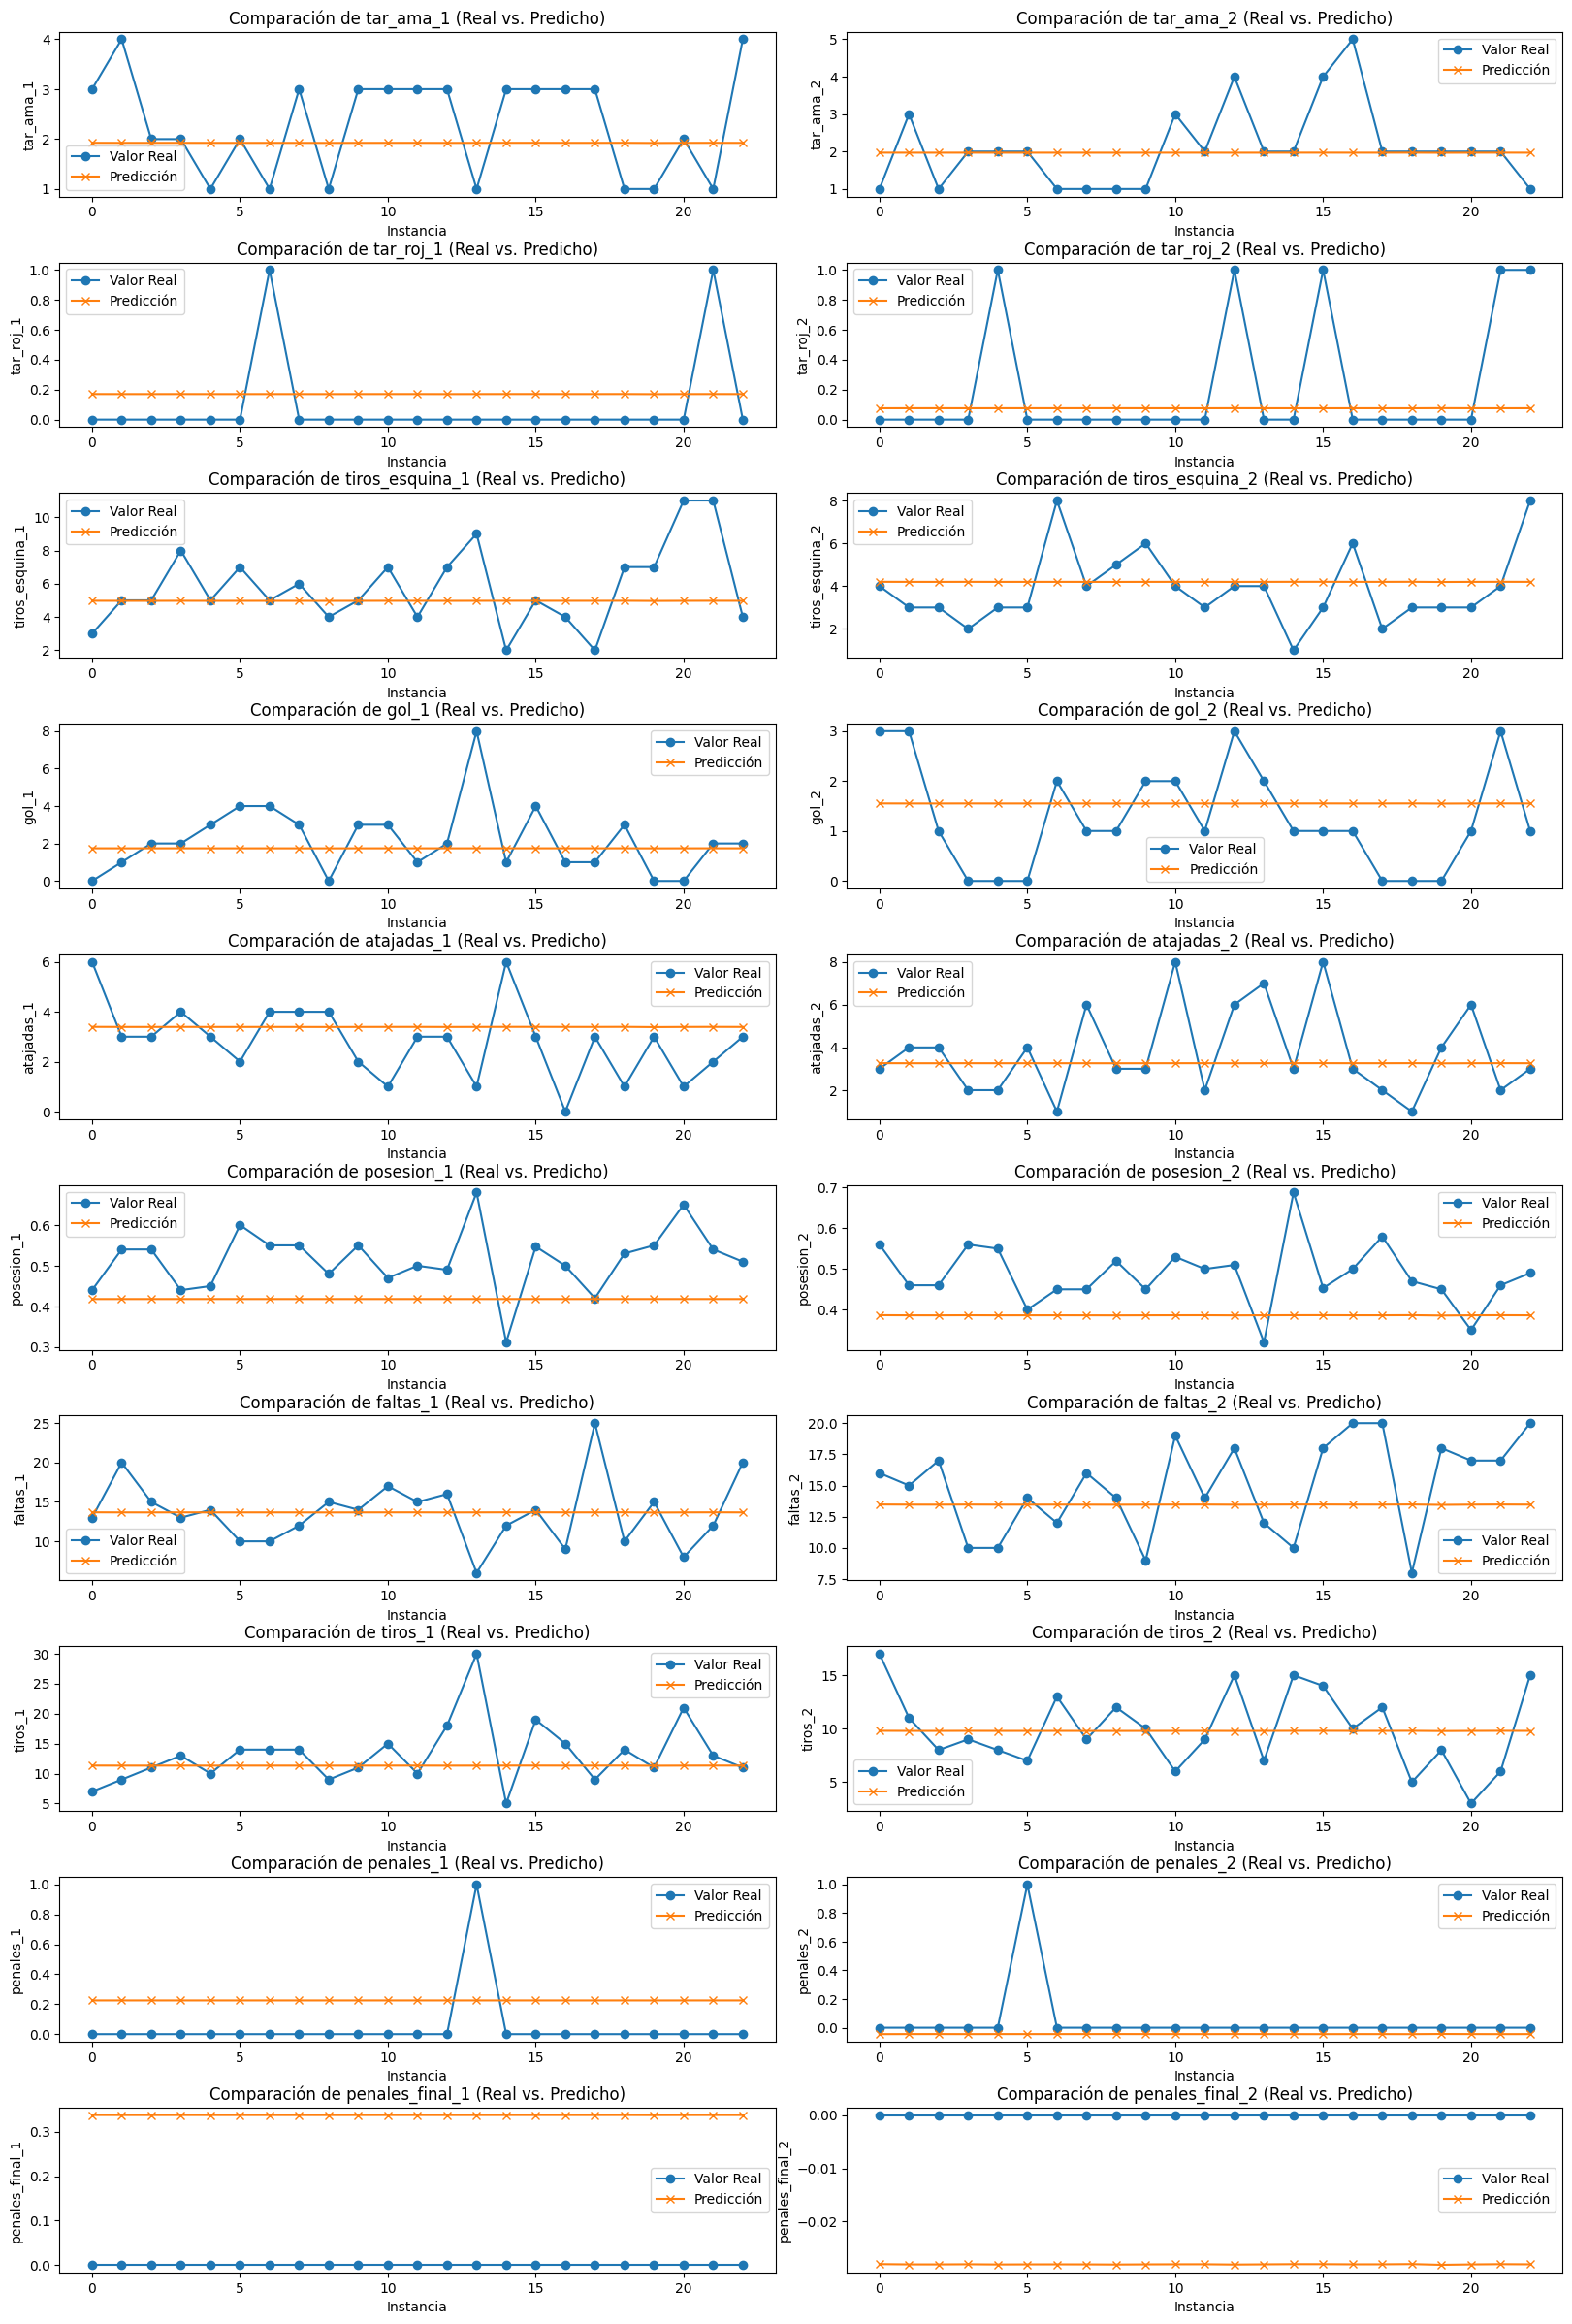

In [167]:
n = 2
fig, axs = plt.subplots(int(test.shape[1]/n), n, figsize=(20, 30))

for i in range(test.shape[1]):

  # Graficar valores reales y predicciones
  axs[int(i/n), i%n].plot(test.iloc[:, i], label='Valor Real', marker='o')
  axs[int(i/n), i%n].plot(y_pred[:, i], label='Predicción', marker='x')

    # Configurar título, etiquetas y leyenda
  axs[int(i/n), i%n].set_title(f'Comparación de {test.columns[i]} (Real vs. Predicho)')
  axs[int(i/n), i%n].set_xlabel('Instancia')
  axs[int(i/n), i%n].set_ylabel(f'{test.columns[i]}')
  axs[int(i/n), i%n].legend()

  axs[int(i/n), i%n].legend()

plt.subplots_adjust(wspace=0.1, hspace=0.4)
plt.show()

In [59]:
X_test_lstm.shape, y_test.shape, X_train_lstm.shape, y_train.shape

((23, 1), (23, 20), (91, 1), (91, 20))

# BERT

In [127]:
import torch
from transformers import BertTokenizer, BertModel

In [129]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Función para convertir texto en embeddings de BERT
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    attention_masks = []

    for text in texts:
        encoding = tokenizer.encode_plus(
            text,
            max_length=max_len,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors='pt'
        )
        all_tokens.append(encoding['input_ids'])
        attention_masks.append(encoding['attention_mask'])

    return torch.cat(all_tokens, dim=0), torch.cat(attention_masks, dim=0)

# Convertir el texto en embeddings de BERT
input_ids, attention_masks = bert_encode(df['lemmatized_Subtitles'], tokenizer)

# Usar BERT para generar embeddings
with torch.no_grad():
    outputs = bert_model(input_ids, attention_mask=attention_masks)
    embeddings = outputs.last_hidden_state[:, 0, :].numpy()  # Usamos la representación [CLS]

In [139]:
embeddings.shape

(114, 768)

In [144]:
# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(embeddings, Y, test_size=0.2, random_state=42)

# Redimensionar los datos para que sean compatibles con LSTM (agregando una dimensión)
X_train_lstm = np.expand_dims(X_train, axis=-1)
X_test_lstm = np.expand_dims(X_test, axis=-1)

In [152]:

model_bert = Sequential([
    LSTM(128, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=False),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.3),  # Añadimos dropout después de la LSTM
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),  # Añadimos dropout antes de la capa final
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),  # Añadimos dropout antes de la capa final
    Dense(Y.shape[1], activation='linear')
])

# Compilar el modelo
model_bert.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model_bert.fit(X_train_lstm,
               y_train,
               epochs=55,
               validation_data=(X_test_lstm, y_test),
               )


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 48.9492 - val_loss: 43.0031
Epoch 2/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 896ms/step - loss: 46.4064 - val_loss: 42.7579
Epoch 3/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 866ms/step - loss: 48.1104 - val_loss: 42.2048
Epoch 4/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 923ms/step - loss: 47.0499 - val_loss: 39.6048
Epoch 5/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 42.4737 - val_loss: 31.0895
Epoch 6/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 866ms/step - loss: 34.8102 - val_loss: 24.1009
Epoch 7/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 900ms/step - loss: 28.8977 - val_loss: 16.6182
Epoch 8/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 23.8751 - val_loss: 11.3202
Epoch 9/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 896ms/step - loss: 20.8445 - val_loss: 8.7409
Epoch 10/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 891ms/step - loss: 20.3952 - val_loss: 8.0350
Epoch 11/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 890ms/step - loss: 17.1316 - val_loss: 8.1349
Epoch 12/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 882ms/step - loss: 15.7

In [153]:
y_pred = model_bert.predict(X_test_lstm)
test =  y_test.reset_index(drop=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


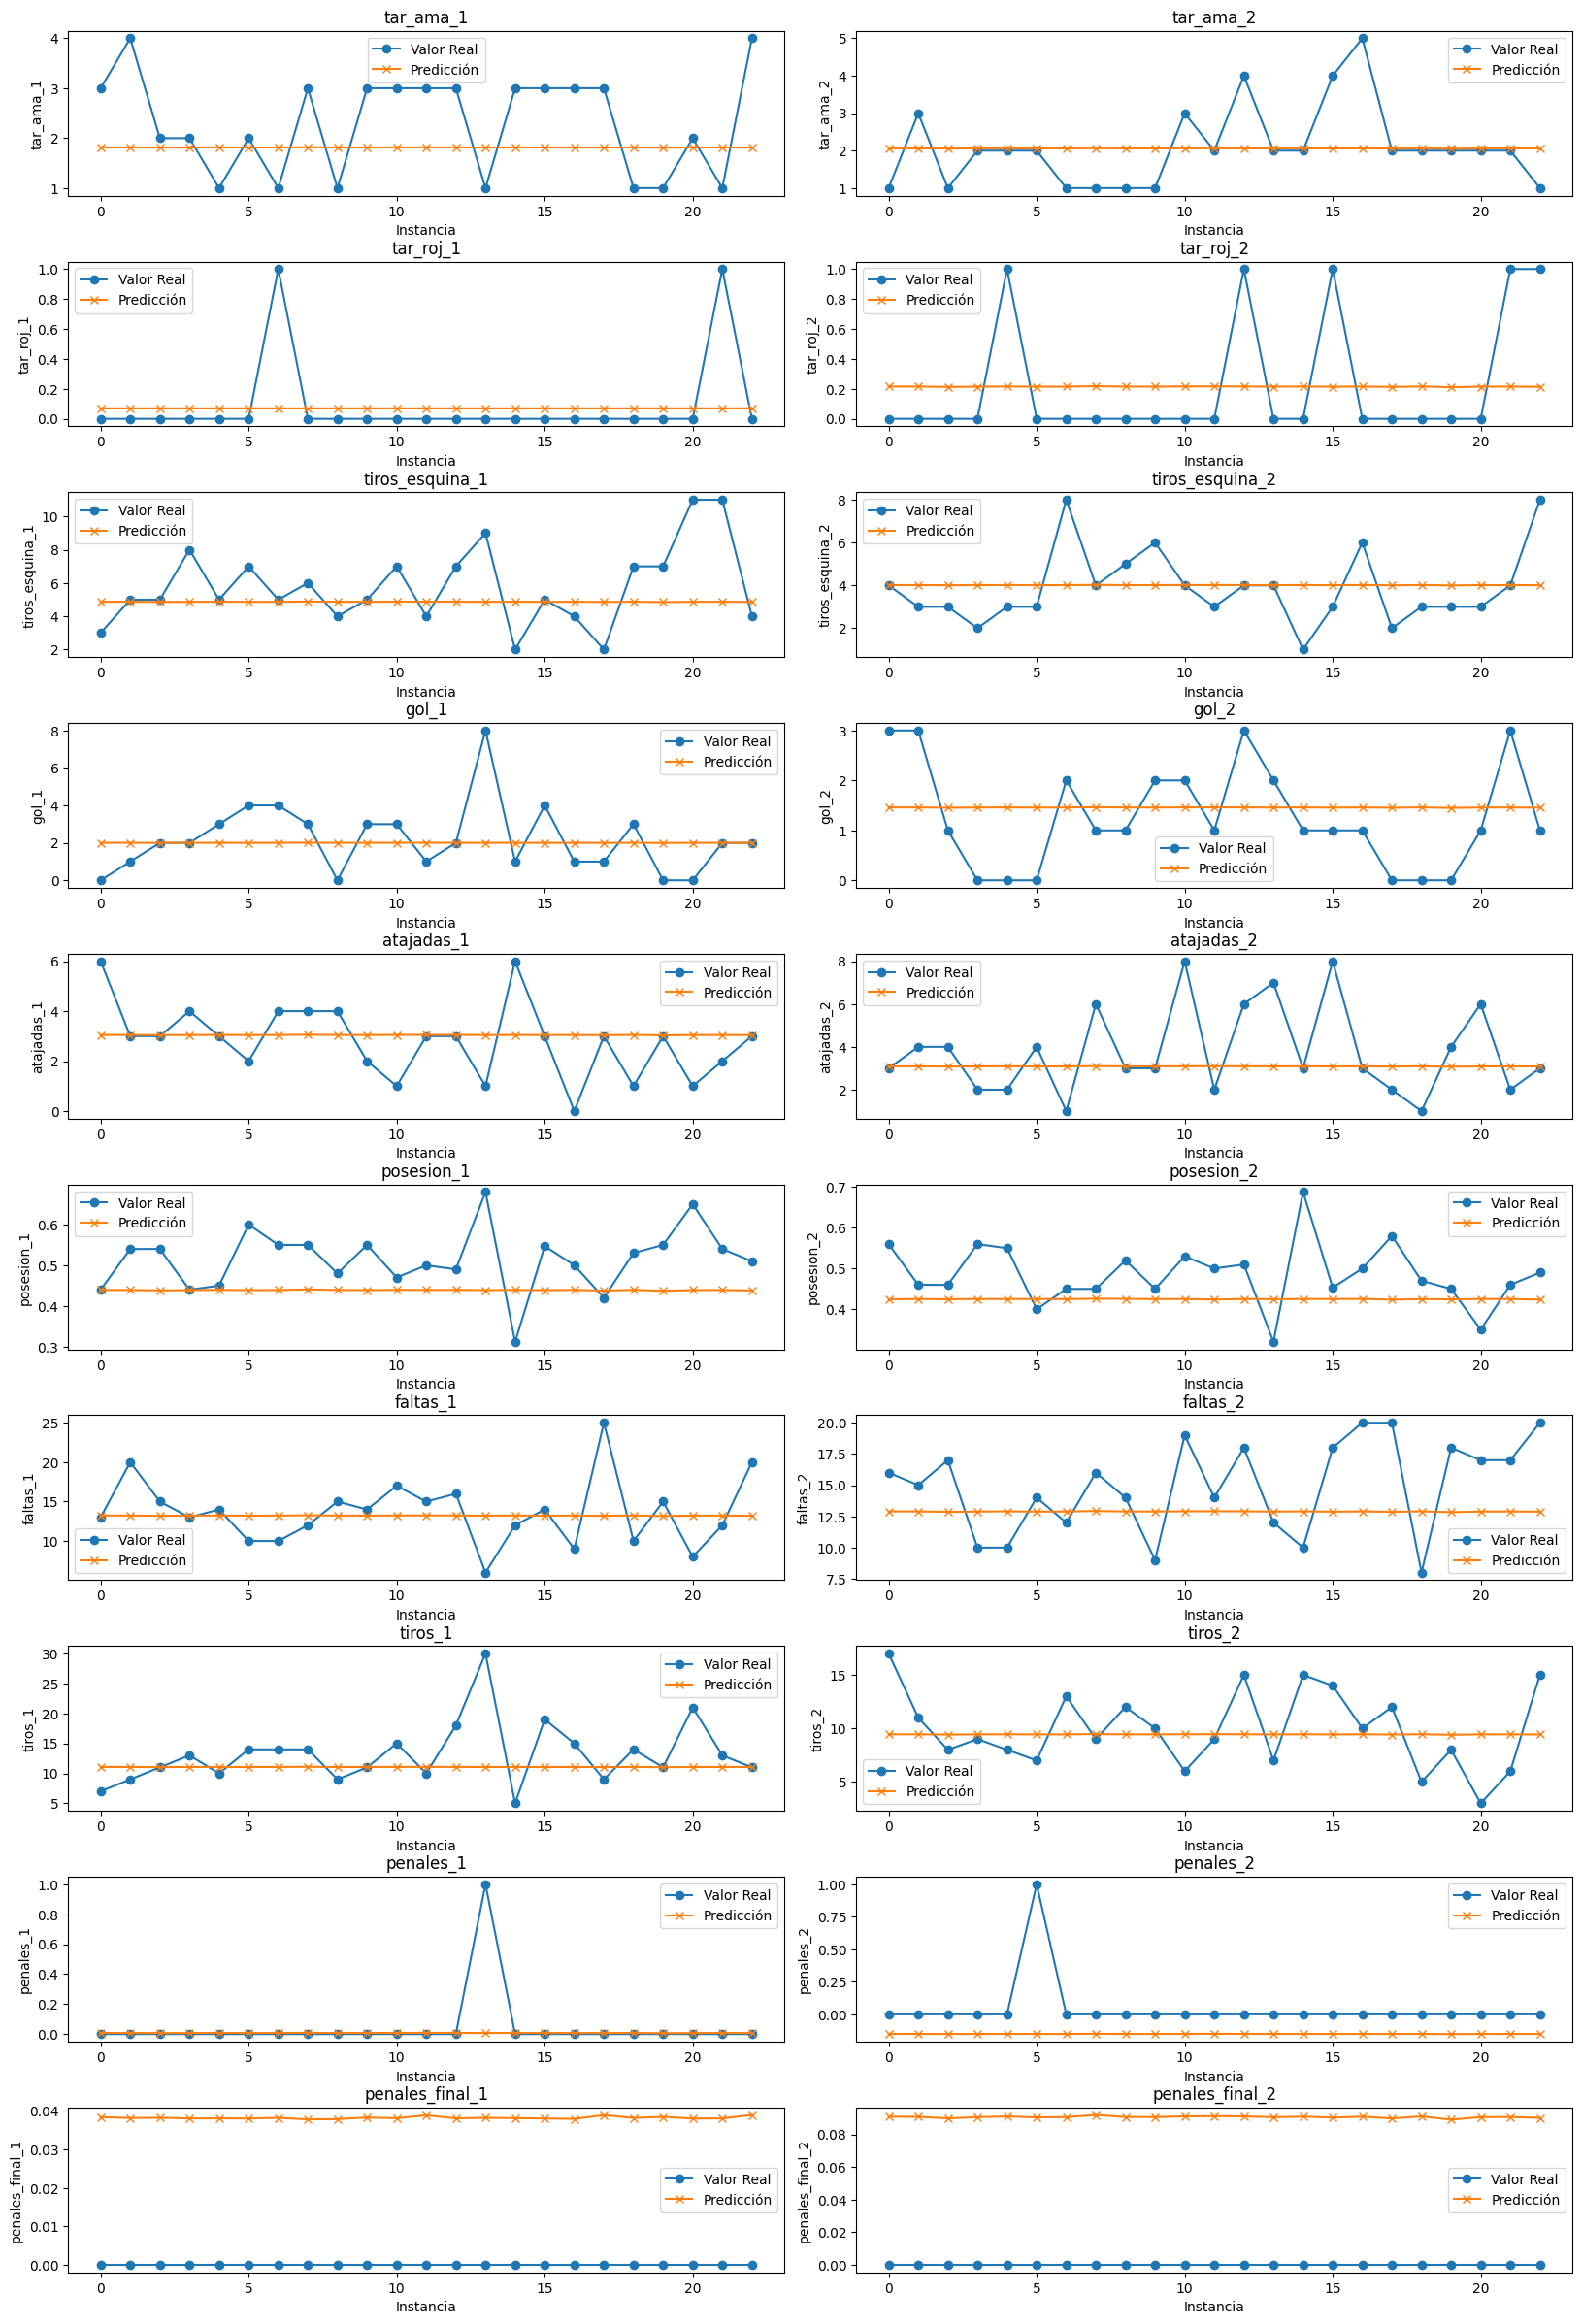

In [154]:
n = 2
fig, axs = plt.subplots(int(test.shape[1]/n), n, figsize=(20, 30))

for i in range(test.shape[1]):

  # Graficar valores reales y predicciones
  axs[int(i/n), i%n].plot(test.iloc[:, i], label='Valor Real', marker='o')
  axs[int(i/n), i%n].plot(y_pred[:, i], label='Predicción', marker='x')

    # Configurar título, etiquetas y leyenda
  axs[int(i/n), i%n].set_title(f'{test.columns[i]}')
  axs[int(i/n), i%n].set_xlabel('Instancia')
  axs[int(i/n), i%n].set_ylabel(f'{test.columns[i]}')
  axs[int(i/n), i%n].legend()

  axs[int(i/n), i%n].legend()

plt.subplots_adjust(wspace=0.1, hspace=0.4)
plt.show()

# Diego

In [50]:
# Definir los patrones de eventos clave utilizando expresiones regulares
event_patterns = {
    'Goles': r'\b(gol|anotacion|marco|marcaron)\b',
    'Tarjetas Amarillas': r'\b(tarjeta amarilla|amonestacion|amarilla)\b',
    'Tarjetas Rojas': r'\b(tarjeta roja|expulsado|expulsion|expulsar|roja|expulsaron)\b',
    'Tiros de Esquina': r'\b(corner|tiro de esquina)\b',
    'Saques de Banda': r'\b(saque de banda)\b',
    'Faltas': r'\b(falta|infraccion|foul|faul)\b',
    'Penales': r'\b(penal|penalty)\b',
    'Posesión de balón': r'\b(posesion)\b',
    'Fueras de juego': r'\b(fuera de juego|offside)\b',
    'Tiros': r'\b(tiro|disparo)\b'
}

# Función para etiquetar un fragmento de texto con el evento correspondiente
def label_events(text):
    labels = []
    for event, pattern in event_patterns.items():
        if re.search(pattern, text, re.IGNORECASE):
            labels.append(event)
    return labels

# Aplicar la función para generar etiquetas
X['Event_Labels'] = X['Cleaned_Subtitles'].apply(label_events)

# Convertir las listas de eventos en una única etiqueta simplificada por fragmento
def simplify_labels(event_list):
    if 'Goles' in event_list:
        return 0  # Goles
    elif 'Tarjetas Amarillas' in event_list:
        return 1  # Tarjeta Amarilla
    elif 'Tarjetas Rojas' in event_list:
        return 2  # Tarjeta Roja
    elif 'Tiros de Esquina' in event_list:
        return 3  # Tiros de Esquina
    elif 'Faltas' in event_list:
        return 4  # Faltas
    elif 'Penales' in event_list:
        return 5  # Penales
    else:
        return 6  # Ningún evento

X['Simplified_Labels'] = X['Event_Labels'].apply(simplify_labels)

KeyError: 'Cleaned_Subtitles'

In [ ]:
# Dividimos los datos en entrenamiento y prueba
train_data, test_data = train_test_split(X_simple, test_size=0.2, random_state=42)

# Aumentamos el tamaño máximo de secuencias para capturar más contexto
maxlen = 200  # Aumentamos el tamaño máximo de la secuencia para capturar más contexto

# Tokenización del texto
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_data['Cleaned_Subtitles'])

train_sequences = tokenizer.texts_to_sequences(train_data['Cleaned_Subtitles'])
test_sequences = tokenizer.texts_to_sequences(test_data['Cleaned_Subtitles'])

# Rellenamos las secuencias para que tengan la misma longitud
X_train = pad_sequences(train_sequences, maxlen=maxlen)
X_test = pad_sequences(test_sequences, maxlen=maxlen)

# Convertimos las etiquetas en arrays
y_train = train_data['Simplified_Labels']
y_test = test_data['Simplified_Labels']

# Definimos el modelo LSTM con dropout
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=128, input_length=maxlen),
    tf.keras.layers.LSTM(256, return_sequences=False),
    tf.keras.layers.Dropout(0.3),  # Añadimos dropout después de la LSTM
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),  # Añadimos dropout antes de la capa final
    tf.keras.layers.Dense(7, activation='softmax')  # 7 clases de eventos
])

# Compilamos el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



# Entrenamos el modelo con más épocas y early stopping
history = model.fit(X_train, y_train,
                    epochs=100,  # Aumentamos las épocas
                    validation_data=(X_test, y_test),
                    batch_size=32,
                    callbacks=[early_stopping])

In [ ]:
# Función para detectar eventos en un fragmento de texto
def detect_events(text):
    event_counts = {event: 0 for event in event_patterns}  # Inicializamos el conteo de eventos
    for event, pattern in event_patterns.items():
        matches = re.findall(pattern, text, re.IGNORECASE)
        event_counts[event] += len(matches)  # Contamos cuántas veces aparece cada evento
    return event_counts

# Función para convertir predicciones de modelos en eventos legibles
def prediction_to_event(pred):
    event_index = np.argmax(pred)
    event_mapping = {0: 'Goles', 1: 'Tarjetas Amarillas', 2: 'Tarjetas Rojas', 3: 'Tiros de Esquina', 4: 'Faltas', 5: 'Penales', 6: 'Ningún evento'}
    return event_mapping[event_index]

# Aplicamos el modelo a nuevas narraciones
predictions = model.predict(X_test)

# Función mejorada para asignar los eventos detectados a Equipo 1 y Equipo 2
def assign_events_to_teams(text, team1_name='Equipo 1', team2_name='Equipo 2'):
    team1_stats = {event: 0 for event in event_patterns}
    team2_stats = {event: 0 for event in event_patterns}

    # Procesamos el texto en oraciones o fragmentos
    sentences = text.split('.')

    # Alternamos entre los equipos para asignar los eventos
    current_team = 1

    for sentence in sentences:
        event_counts = detect_events(sentence)

        # Asignar los eventos al equipo correspondiente
        if current_team == 1:
            for event, count in event_counts.items():
                team1_stats[event] += count
            current_team = 2  # Alternamos al Equipo 2
        else:
            for event, count in event_counts.items():
                team2_stats[event] += count
            current_team = 1  # Volvemos al Equipo 1

    return team1_stats, team2_stats

# Generar estadísticas para las narraciones de prueba
for i in range(10):  # Revisamos las primeras 5 narraciones para verificar las predicciones y las estadísticas
    print(f"Narración: {test_data['Cleaned_Subtitles'].iloc[i]}")
    print(f"Predicción del evento: {prediction_to_event(predictions[i])}")
    team1_stats, team2_stats = assign_events_to_teams(test_data['Cleaned_Subtitles'].iloc[i])
    print(f'Estadísticas Equipo 1: {team1_stats}')
    print(f'Estadísticas Equipo 2: {team2_stats}')
    print('---')


# Guardar Modelos


In [155]:
import joblib

joblib.dump(model, "/content/drive/MyDrive/Maestria/Proyecto_fut/lstm.jolib")
joblib.dump(model_bert, "/content/drive/MyDrive/Maestria/Proyecto_fut/lstm_bert.jolib")

['/content/drive/MyDrive/Maestria/Proyecto_fut/lstm_bert.jolib']